In [1]:
import argparse

import numpy as np
import torch
import torch.nn as nn
import fnmatch
import os

### Define dataset

In [2]:
def readDATA(fileDir, vis=False):
    words,vectors = [], []
    with open(fileDir) as infile: # wherever you store the vectors
        for line in infile:
            line = line.strip()
            line = line.split(",")
            words.append(line[0])
            vect = line[1:len(line)]
            vect = [float(t) for t in vect]
            #if vis:
            #    vect = np.expand_dims(vect, axis=0)
            vectors.append(vect)
        vectors = np.array(vectors)
    return words, vectors

In [3]:
lb_ts, EMB_ts_vis = readDATA('iaprtc/TS_vis_vgg128.csv', True)
_, EMB_ts_lang = readDATA('iaprtc/TS_lang_biGRU.csv')
lb_tr, EMB_tr_vis = readDATA('iaprtc/TR_vis_vgg128.csv', True)
_, EMB_tr_lang = readDATA('iaprtc/TR_lang_biGRU.csv')

In [4]:
len(lb_ts), len(EMB_ts_vis), len(EMB_ts_lang), len(lb_tr)

(1962, 1962, 1962, 17665)

In [5]:
EMB_ts_vis.shape

(1962, 128)

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

class MultimodalDataset(Dataset):

    def __init__(self, vids, words, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.vids = vids
        self.caps = words

    def __len__(self):
        return len(self.vids)

    def __getitem__(self, idx):
        vid_feat = self.vids[idx]
        word_feat = self.caps[idx]

        sample = {'vid_feat': vid_feat, 'word_feat': word_feat}

        return sample

### Define autoencoder

In [123]:
class VideoEncoder(torch.nn.Module):

    def __init__(self,
                 C,
                 N,
                 num_feats,
                 drop_out):
        super(VideoEncoder, self).__init__()

        self.C = C
        self.N = N
        self.num_feats = num_feats
        mid = int((N+C)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(num_feats, C),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(C, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, N)
        )     

    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class VideoDecoder(torch.nn.Module):

    def __init__(self,
                 C,
                 N,
                 num_feats,
                 drop_out):
        super(VideoDecoder, self).__init__()

        self.C = C
        self.N = N
        self.num_feats = num_feats
        mid = int((num_feats+C)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(N, C),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(C, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, num_feats)
        )  
        
    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class WordEncoder(torch.nn.Module):

    def __init__(self,
                 L,
                 N,
                 num_feats,
                 drop_out):
        super(WordEncoder, self).__init__()

        self.L = L
        self.N = N
        self.num_feats = num_feats
        mid = int((L+N)/2)
        
        self.fc = nn.Sequential(
            nn.Linear(num_feats, L),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(L, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, N)
        )

    def forward(self, inp):
        out = self.fc(inp)
        return out
    
class WordDecoder(torch.nn.Module):

    def __init__(self,
                 L,
                 N,
                 num_feats,
                 drop_out):
        super(WordDecoder, self).__init__()

        self.L = L
        self.N = N
        self.num_feats = num_feats
        mid = int((L+num_feats)/2)
        self.fc = nn.Sequential(
            nn.Linear(N, L),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(L, mid),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(mid, num_feats)
        )

    def forward(self, inp):
        out = self.fc(inp)
        return out

### Define parameters

In [314]:
num_epochs = 100
batch_size = 2048
learning_rate = 1e-5
weight_decay = 1e-5
drop_out = 0.5

C = 64 # mid bottleneck for video
N = 64 # representation dim
V = 128 # feature vector size for vgg
L = 64 # mid bottleneck for text
D = 64 # gru feature size 

train_data = MultimodalDataset(vids=EMB_tr_vis[:-1962], words=EMB_tr_lang[:-1962])
val_data = MultimodalDataset(vids=EMB_tr_vis[-1962:], words=EMB_tr_lang[-1962:])
test_data = MultimodalDataset(vids=EMB_ts_vis, words=EMB_ts_lang)
dataloaders_dict = {
    'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
}

print("Video autoencoder::: ")
enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)

print("Word autoencoder::: ")
enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)


optim1 = torch.optim.Adam(enc_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim2 = torch.optim.Adam(dec_vid.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim3 = torch.optim.Adam(enc_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
optim4 = torch.optim.Adam(dec_word.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.MSELoss()

Video autoencoder::: 
Word autoencoder::: 


In [315]:
EMB_ts_lang.shape

(1962, 64)

## Train the model

In [316]:
device = torch.device('cuda:0')
enc_vid = enc_vid.to(device)
dec_vid = dec_vid.to(device)
enc_word = enc_word.to(device)
dec_word = dec_word.to(device)

In [317]:
enc_vid = nn.DataParallel(enc_vid)
dec_vid = nn.DataParallel(dec_vid)
enc_word = nn.DataParallel(enc_word)
dec_word = nn.DataParallel(dec_word)

In [318]:
len(dataloaders_dict['train'].dataset), len(dataloaders_dict['val'].dataset), len(dataloaders_dict['test'].dataset)

(15703, 1962, 1962)

In [319]:
print(enc_vid)

DataParallel(
  (module): VideoEncoder(
    (fc): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.5)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.5)
      (6): Linear(in_features=64, out_features=64, bias=True)
    )
  )
)


## TRAIN

In [320]:
import time
import copy

since = time.time()

train_acc_history = []
val_acc_history = []

best_enc_vid = VideoEncoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_dec_vid = VideoDecoder(C=C, N=N, num_feats=V, drop_out=drop_out)
best_enc_word = WordEncoder(L=L, N=N, num_feats=D, drop_out=drop_out)
best_dec_word = WordDecoder(L=L, N=N, num_feats=D, drop_out=drop_out)


best_loss = 1000000.0

num_epochs=200



for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            # Set model to training mode
            enc_vid.train()
            dec_vid.train()
            enc_word.train()
            dec_word.train()
        else:
            enc_vid.eval()
            dec_vid.eval()
            enc_word.eval()
            dec_word.eval()
            
        running_loss = 0.0
        l_recons, l_joint, l_cross = 0.0, 0.0, 0.0
        running_l_recons, running_l_joint, running_l_cross = 0.0, 0.0, 0.0
        running_l_rank = 0.0
        optim1.zero_grad()
        optim2.zero_grad()
        optim3.zero_grad()
        optim4.zero_grad()
        
        for data in dataloaders_dict[phase]:
                        
            videos = torch.chunk(data["vid_feat"],2)
            words = torch.chunk(data["word_feat"], 2)            
        
            video = videos[0].float().to(device)
            word = words[0].float().to(device)
            
            video_n = videos[1].float().to(device)
            word_n = words[1].float().to(device)
            
            
            with torch.set_grad_enabled(phase == 'train'):
                try:
                    mid_video = enc_vid(video)
                except RuntimeError as err:
                    print(video.shape)
                    print("mid video cannot create: ", err)
                    break
                out_video = dec_vid(mid_video)
                loss1 = criterion(out_video, video)

                mid_word = enc_word(word)
                out_word = dec_word(mid_word)
                loss2 = criterion(out_word, word)

                l_recons = loss1+loss2

                cos = nn.CosineSimilarity(dim=1, eps=1e-6)
                
                mid_word_n = enc_word(word_n)
                
                try:
                    sim1 = cos(mid_video, mid_word)
                    sim2 = cos(mid_video, mid_word_n)
                except:
                    break
                
                
                marg_loss = torch.nn.MarginRankingLoss(margin=0.2)
                
                target = torch.ones(len(sim1)).to(device)
                
                l_rank_joint = marg_loss(sim1, sim2, target)
                # print(l_rank_joint)
                
                #output = cos(input1, input2)
                
                l_joint = criterion(mid_video, mid_word)

                cross_words = dec_word(mid_video)
                cross_video = dec_vid(mid_video)
                l_cross = criterion(cross_words, word) + criterion(cross_video, video)

                alpha1, alpha2, alpha3 = 1, 10, 10
                loss = alpha1*l_recons + alpha2*l_rank_joint + alpha3*l_cross
                
                running_loss += loss.item()
                running_l_recons += l_recons.item()
                running_l_joint += l_joint.item()
                running_l_cross += l_cross.item()
                running_l_rank += l_rank_joint.item()

                if phase == 'train':
                    optim1.zero_grad()
                    optim2.zero_grad()
                    optim3.zero_grad()
                    optim4.zero_grad()
                    loss.backward()
                    optim1.step()
                    optim2.step()
                    optim3.step()
                    optim4.step()
            
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        
        if phase == 'train':
            train_acc_history.append(epoch_loss)
        
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_enc_vid = copy.deepcopy(enc_vid.state_dict())
                best_dec_vid = copy.deepcopy(dec_vid.state_dict())
                best_enc_word = copy.deepcopy(enc_word.state_dict())
                best_dec_word = copy.deepcopy(dec_word.state_dict())
            val_acc_history.append(epoch_loss)
            if epoch%5 ==0:
                print('epoch [{}/{}], epoch_loss:{:.8f}, l_recons:{:.8f}, l_joint:{:.8f}, l_rank:{:.8f}, l_cross:{:.8f}'
                      .format(epoch + 1, num_epochs, epoch_loss, running_l_recons, running_l_joint, running_l_rank, running_l_cross))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

torch.save(enc_vid.state_dict(), './video_encoder.pth')
torch.save(dec_vid.state_dict(), './video_decoder.pth')
torch.save(enc_word.state_dict(), './word_encoder.pth')
torch.save(enc_word.state_dict(), './word_decoder.pth')

epoch [1/200], epoch_loss:104.88525391, l_recons:9.34634209, l_joint:0.10150284, l_rank:0.20571601, l_cross:9.34817505
epoch [6/200], epoch_loss:107.00141907, l_recons:9.54281902, l_joint:0.09897341, l_rank:0.20163822, l_cross:9.54422188
epoch [11/200], epoch_loss:106.79114532, l_recons:9.52919960, l_joint:0.09674732, l_rank:0.19586298, l_cross:9.53033161
epoch [16/200], epoch_loss:103.62257385, l_recons:9.24072456, l_joint:0.09523950, l_rank:0.19644569, l_cross:9.24173927
epoch [21/200], epoch_loss:104.59493256, l_recons:9.32517815, l_joint:0.10033169, l_rank:0.20108902, l_cross:9.32588673
epoch [26/200], epoch_loss:104.61854553, l_recons:9.32884502, l_joint:0.10641528, l_rank:0.19954963, l_cross:9.32942009
epoch [31/200], epoch_loss:103.66427612, l_recons:9.24507523, l_joint:0.11413161, l_rank:0.19640604, l_cross:9.24551392
epoch [36/200], epoch_loss:103.54711151, l_recons:9.23183155, l_joint:0.12724289, l_rank:0.19944865, l_cross:9.23207951
epoch [41/200], epoch_loss:105.77484131, l

In [321]:
best_loss

69.15544128417969

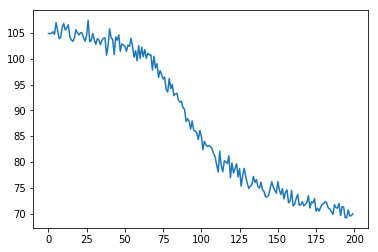

In [322]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history)
plt.show()

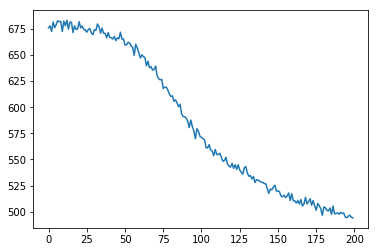

In [323]:
plt.plot(train_acc_history)
plt.show()

### Evaluate on test data

In [324]:
enc_vid.eval()
dec_vid.eval()
enc_word.eval()
dec_word.eval()

eval_loss = []
check_similarities = False
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

similarities= {}
acc = 0
c = 0

mNNOs = []

torch.set_grad_enabled(False)

data_size=(EMB_ts_lang.shape)[0]

vid_inputs = torch.zeros((data_size, 128))
word_inputs = torch.zeros((data_size, 64))
vid_to_word = torch.zeros((data_size, 64))
word_to_vid = torch.zeros((data_size, 128))

for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)
    #label = data["label"][0]
    #print("video shape: ", video.squeeze(0).shape)
    
    try:
        mid_video = enc_vid(video)
    except RuntimeError as err:
        print("eror:", err)
        break
    out_video = dec_vid(mid_video)
    loss1 = criterion(out_video, video)

    mid_word = enc_word(word)
    out_word = dec_word(mid_word)
    loss2 = criterion(out_word, word)

    l_recons = loss1+loss2

    #l_joint = criterion(mid_video, mid_word)

    #cross_words = dec_word(mid_video)
    #cross_video = dec_vid(mid_video)
    #l_cross = criterion(cross_words, word) + criterion(cross_video, video)

    #alpha1, alpha2, alpha3 = 1, 1, 1
    #loss = l_recons + alpha1 * l_joint + alpha2 * l_cross
    loss = l_recons
    
    #print("data: {}, \n" , c)
    #print('  mid video: {} ,  out video:{}'.format(mid_video[0][:5], out_video[0][:5]))
    #print('  mid word: {} ,  out word:{}'.format(mid_word[0][:5], out_word[0][:5]))
    #print(out_word[0])
    
    vid_inputs[c]=video.squeeze(0)
    word_inputs[c]=word.squeeze(0)
    vid_to_word[c]=out_word.squeeze(0)
    word_to_vid[c]=out_video.squeeze(0)
    
    #print(loss.item())
    eval_loss.append(loss.item())
    c+=1
    
#print("val loss: ", np.mean(eval_loss))

In [326]:
vid_inputs.shape, word_inputs.shape, vid_to_word.shape, word_to_vid.shape

(torch.Size([1962, 128]),
 torch.Size([1962, 64]),
 torch.Size([1962, 64]),
 torch.Size([1962, 128]))

In [311]:
print("val loss: ", np.mean(eval_loss))

val loss:  5.578561305695961


## EVALUATE MNNOs

In [327]:
import eval_utils

k_neighbors = 30
sim = 'cosine'

#perf = eval_utils.eval_performance(EMB_in=vid_inputs, EMB_out=word_inputs, EMB_map=vid_to_word, sim=sim, k_neighbors, False)
perf = eval_utils.eval_performance(vid_inputs.numpy(), word_inputs.numpy(), vid_to_word.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.097  || MNNO(f(X),Y)= 0.257  || MNNO(Y,X)= 0.162  || mse= 0.49538  || R2= -0.4036


In [328]:
perf = eval_utils.eval_performance(word_inputs.numpy(), vid_inputs.numpy(), word_to_vid.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.1  || MNNO(f(X),Y)= 0.236  || MNNO(Y,X)= 0.162  || mse= 5.57866  || R2= -0.0842


## TEST MNNO FOR LINEAR LAYER

In [329]:
linear_mapping = nn.Linear(V, D).to(device)
linear_mapping = nn.DataParallel(linear_mapping)

In [338]:
linear_mapping2 = nn.Linear(D, V).to(device) # Text to video
linear_mapping2 = nn.DataParallel(linear_mapping2)

In [339]:
num_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-5
drop_out = 0.3

optim = torch.optim.Adam(linear_mapping2.parameters(), lr=learning_rate, weight_decay = weight_decay)
criterion = nn.MSELoss()

In [340]:
import time
import copy

since = time.time()

train_acc_history = []
val_acc_history = []

best_loss = 1000000.0

num_epochs=100

for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            # Set model to training mode
            linear_mapping2.train()
        else:
            linear_mapping2.eval()
            
        optim.zero_grad()
        running_loss = 0.0
        
        for data in dataloaders_dict[phase]:
            
            video = data["vid_feat"].float().to(device)
            word = data["word_feat"].float().to(device)

            with torch.set_grad_enabled(phase == 'train'):
                
                out_video = linear_mapping2(word)
                loss = criterion(out_video, video)
                running_loss += loss.item()

                if phase == 'train':
                    optim.zero_grad()
                    loss.backward()
                    optim.step()
                    
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        
        if phase == 'train':
            train_acc_history.append(epoch_loss)
        
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
            val_acc_history.append(epoch_loss)
            if epoch%25 ==0:
                print('epoch [{}/{}], loss:{:.8f}'
                      .format(epoch + 1, num_epochs, epoch_loss))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

epoch [1/100], loss:8.62404823
epoch [26/100], loss:5.04593420
epoch [51/100], loss:4.48589897
epoch [76/100], loss:4.33453703
Training complete in 0m 18s
Best val Acc: 4.273274


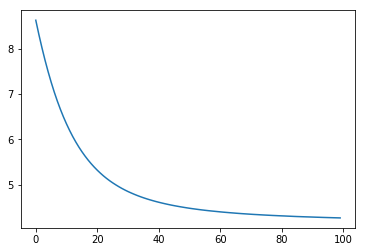

In [341]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history)
plt.show()

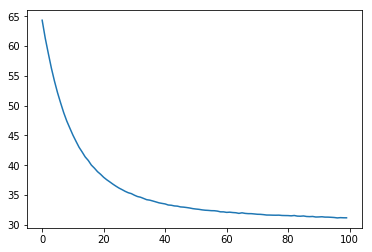

In [342]:
plt.plot(train_acc_history)
plt.show()

In [344]:
linear_mapping.eval()

eval_loss = []
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

c = 0

mNNOs = []

torch.set_grad_enabled(False)

data_size=(EMB_ts_lang.shape)[0]

vid_inputs = torch.zeros((data_size, 128))
word_inputs = torch.zeros((data_size, 64))
vid_to_word = torch.zeros((data_size, 64))
word_to_vid = torch.zeros((data_size, 128))

for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)
    
    
    out_video = linear_mapping2(word)
    loss = criterion(out_video, video)
    
    #print("data: {}, \n" , c)
    #print('  mid video: {} ,  out video:{}'.format(mid_video[0][0][:5], out_video[0][0][:5]))
    #print(' out word:{}'.format(out_word[0][:5]))
    
    vid_inputs[c]=video.squeeze(0)
    word_inputs[c]=word.squeeze(0)
    #vid_to_word[c]=out_word.squeeze(0)
    word_to_vid[c]=out_video.squeeze(0)
    
    eval_loss.append(loss.item())
    c+=1

In [345]:
print("val loss: ", np.mean(eval_loss))

val loss:  4.147771962738912


In [346]:
perf = eval_utils.eval_performance(vid_inputs.numpy(), word_inputs.numpy(), vid_to_word.numpy(), sim, k_neighbors, True)


print('TEST: MNNO(f(X),X)=', round(perf['mnno_map-in'],3),
                                      ' || MNNO(f(X),Y)=', round(perf['mnno_map-out'],3),
                                      ' || MNNO(Y,X)=', round(perf['mnno_in-out'],3),
                                      ' || mse=', round(perf['mse'],5), ' || R2=', round(perf['R2'],4))

TEST: MNNO(f(X),X)= 0.049  || MNNO(f(X),Y)= 0.049  || MNNO(Y,X)= 0.162  || mse= 0.50219  || R2= -0.4085


In [294]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)


In [337]:
len(output)

128